<a href="https://colab.research.google.com/github/jiin124/Kaggle/blob/main/Trip%20Advisor%20Hotel%20Reviews/%F0%9F%91%8D%F0%9F%91%8ESentiment_Analysis_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
df=pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# Importing Libraries

In [5]:
import string
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer#뭐임 이거
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Models
import torch
from tqdm import tqdm
torch.cuda.is_available()

True

The SnowballStemmer class

SnowballStemmer는 영어 외의 13개 국가의 언어에대한 Stemming을 지원한다.
출처: https://excelsior-cjh.tistory.com/67 [EXCELSIOR:티스토리]

# Data Visualization

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

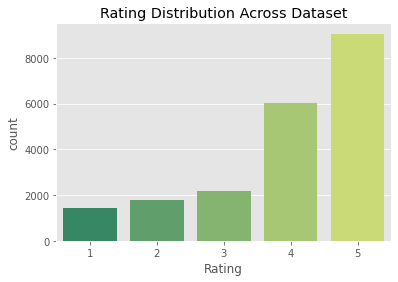

In [6]:
sns.countplot(data=df,x='Rating',palette='summer').set_title('Rating Distribution Across Dataset')

# Text Preprocessing

In [7]:
def rating(score):
  if score>3:
    return 2
  elif score==3:
    return 1
  else:
    return 0

In [8]:
df['Rating']=df['Rating'].apply(rating)

In [9]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,1
3,"unique, great stay, wonderful time hotel monac...",2
4,"great stay great stay, went seahawk game aweso...",2


# Stemming vs Lemmatization

In [14]:
print('Original:')
print(df['Review'][0])
print()

sentence=[]
for word in df['Review'][0].split():
  stemmer=SnowballStemmer('english')
  sentence.append(stemmer.stem(word))

print('Stemming')
print(' '.join(sentence))
print()

sentence=[]
for word in df['Review'][0].split():
  lemmatizer=WordNetLemmatizer()
  sentence.append(lemmatizer.lemmatize(word,'v'))

print('Lemmatization : ')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath product

Lemmatization 사용하는게 나아 보인다 허허

In [15]:
def cleansing(text):
  clean_text=text.translate(str.maketrans('','',string.punctuation)).lower()#maketrans 뭥미 검색하니까 트랜스젠더 나옴

  #remove stopwords
  clean_text=[word for word in clean_text.split() if word not in stopwords.words('english')]
  
  #lemmatize the word
  sentence=[]
  for word in clean_text:
    lemmatizer=WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word,'v'))

  return ' '.join(sentence)


- string.maketrans()
문자열을 치환해주는 함수, 숫자가능, 단 바꾸기전 후 문자의 길이가 같아야 한다. 

In [16]:
df['Review']=df['Review'].apply(cleansing)

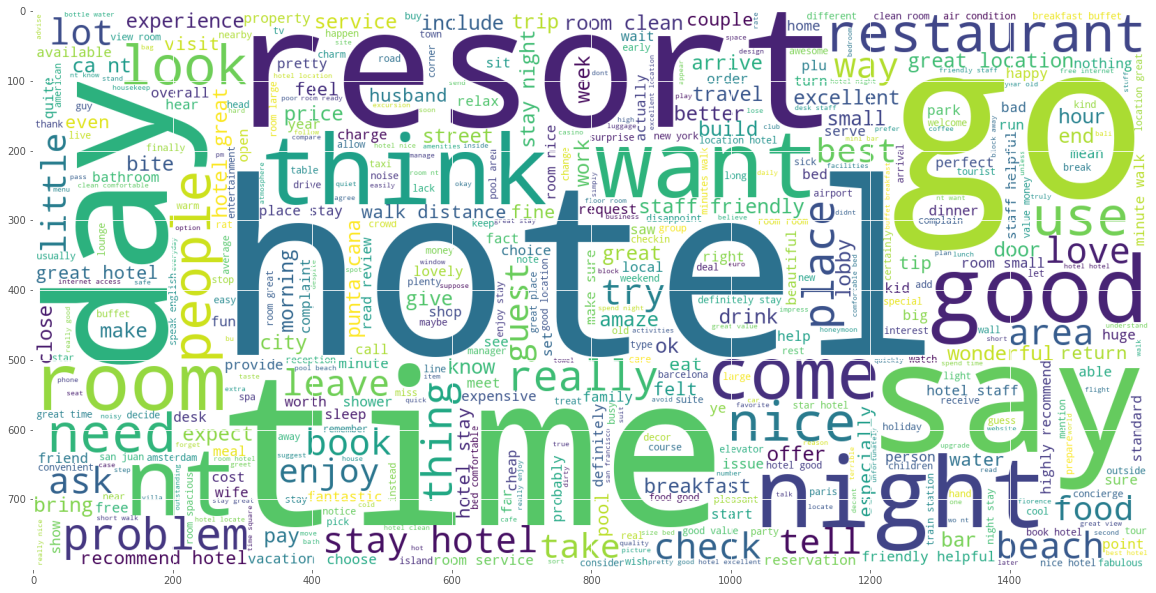

In [17]:
plt.figure(figsize=(20,20))

wc=WordCloud(max_words=1000,min_font_size=10,
             height=800,width=1600,background_color="white").generate(' '.join(df['Review']))

plt.imshow(wc)

In [18]:
df.to_csv("data.csv")

In [19]:
df=pd.read_csv('data.csv')

In [20]:
df.head()

,Unnamed: 0,Review,Rating
0,0,nice hotel expensive park get good deal stay h...,2
1,1,ok nothing special charge diamond member hilto...,0
2,2,nice room 4 experience hotel monaco seattle go...,1
3,3,unique great stay wonderful time hotel monaco ...,2
4,4,great stay great stay go seahawk game awesome ...,2


In [21]:
X_train,X_test,y_train,y_test=train_test_split(df['Review'],df['Rating'],test_size=0.2)

# Building Model with Pytorch

In [22]:
tokenizer=Tokenizer(num_words=10000,oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
total_word=len(tokenizer.word_index)#total_word
print('Total distinct words: {}'.format(total_word))


Total distinct words: 64886


In [26]:
X_train=tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(X_train,maxlen=100)

X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test,maxlen=100)

In [28]:
X_train[:2]

array([[  96,    3,   10,  199,   35,  703, 1278,  991,  286,  614,   23,
           3,    6,  177, 2554, 5747,   80,  302,   63,   38,   25,   37,
        8013, 1201,    5,   78,   45, 1557,  110,  123,  640,   33,  626,
          24,   84,  558, 1314,    6,   61,  419,  144, 2661,  389, 2427,
           1, 1404,  675,   19,  628,   66,  347,  319,  307, 1118, 2285,
        2207,  111, 1040,  108, 1607,    1,  286,    5, 2615,   66,   55,
         836,  545,   89,    3,  305, 1219,  305,  286,   28, 4230,   29,
         111,  122,  204,   99, 4758, 9308,    3,  433, 3739,   97,    3,
         652,    3,  590,    1,  149, 5541,   19,  582,   24,   71,  128,
          66],
       [ 188, 2410, 3156,  234,   33,  442,   32,    2,  232,  593,    3,
          38,   11, 2616,    8,  160,    4,    3,  271,  609,   38,  919,
          10, 1073,  662,  182,   26, 1193,    2,  253,    1,   11, 2410,
        3156, 1408,  671,  609, 3812,   92,  402,   85,  550,  139,   94,
          15,  219,   2

In [29]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [30]:
y_train

array([0, 2, 2, ..., 0, 2, 2])

In [46]:
class SentimentAnalysis(torch.nn.Module):

    def __init__(self, total_word, embed_size, hidden_size, num_class, padding_index=0):
        super().__init__()
        self.total_word = total_word
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        
        self.embed = torch.nn.Embedding(num_embeddings=total_word, 
                                        embedding_dim=embed_size, 
                                        padding_idx=padding_index)
        
        self.lstm = torch.nn.LSTM(input_size=self.embed_size, 
                                  hidden_size=self.hidden_size, 
                                  num_layers=1,
                                  bidirectional=True,
                                  batch_first=True)
        
        self.classifier = torch.nn.Sequential(
            # TODO: add more Linear layer, Activation layer
            torch.nn.Linear(in_features=2*self.hidden_size, out_features=num_class)
        )
        
    def forward(self, X):
        out = self.embed(X)
        out, _ = self.lstm(out)
        out = self.classifier(out[:, -1, :])
        return out

In [47]:
NUM_VOCAB=total_word
EMBED_SIZE=128
HIDDEN_SIZE=164
NUM_CLASS=3
BATCH_SIZE=64
EPOCH=5

In [48]:
model=SentimentAnalysis(total_word=NUM_VOCAB,embed_size=EMBED_SIZE,hidden_size=HIDDEN_SIZE,num_class=NUM_CLASS)

model=model.to("cuda")

In [49]:
loss_func=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.0001)

In [ ]:
num_train = X_train.shape[0]
inds = np.arange(num_train)
for e in range(EPOCH):
    np.random.shuffle(inds)
    pbar = tqdm(range(0, X_train.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
    for i in pbar:
        x = torch.Tensor(X_train[inds[i:i+BATCH_SIZE]])
        x = x.type(dtype=torch.IntTensor).to("cuda")
        y_hat = model(x)
        y = torch.Tensor(y_train[inds[i:i+BATCH_SIZE]])
        y = y.type(dtype=torch.LongTensor).to("cuda")
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description("Epoch: {} - Loss: {}".format(e+1, loss.item()))
    

# prediction

In [51]:
model.eval()
with torch.no_grad():
  x=torch.Tensor(X_test)
  x=x.type(dtype=torch.IntTensor).to("cuda")
  y_hat=model(x)

In [52]:
pred=y_hat.argmax(-1)
pred=pred.cpu().numpy()

In [53]:
print("accuracy :",np.sum(pred==y_test)/y_test.shape[0])

accuracy : 0.7865333008050744


어떻게 bert보다 lstm이 좋을수가 있냐고 ~~~~~~~~~~~~~~~~~~~